## Regresion Logistica Binomial

#### Paso 1: Librerías

In [1]:
##Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

## Funciones

In [2]:
### Función cargar data sea .csv o .xlsx
def importDatos(ruta, archivo, ext):
    if ext == '.csv':
        data = pd.read_csv(ruta+archivo+ext)
        return data
    elif ext == '.xlsx':
        data = pd.read_excel(ruta+archivo+ext)
        return data
    else:
        print('Extensión Diferente')

# Función para reemplazo de valore numéricos con la mediana
def imputacionNa(df, nomCol, param):
    if param == 'media':
        df[nomCol] = df[nomCol].fillna(df[nomCol].mean())
        return df[nomCol]
    else:
        df[nomCol] = df[nomCol].fillna(df[nomCol].median())
        return df[nomCol]

# Función para reeemplazo NA categóricos
def imputacionCatNa(df, nomCol):
    df[nomCol] = df[nomCol].fillna(df[nomCol].mode()[0])
    return df[nomCol]

# Función para datos categóricos modificaciones
def imputacionCat(df, nomCol, busqueda, reempl):
    df[nomCol] = np.where(df[nomCol] == busqueda, reempl, df[nomCol])
    return df[nomCol]

# Función para variables dummies
def convDummies(df, nomCol):
    dummies = pd.get_dummies(df[nomCol])
    data = pd.concat([df, dummies], axis=1)
    data.drop(columns=[nomCol], inplace=True)
    return data

# Funcion para revisar datos categóricos o texto
def revCategoricos(df, nomCol):
    rev = df[nomCol].value_counts()
    return rev
    
## Función para datos NAN -> Null -> 0 (IRQ) -> NAN
def datos_NAN(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimesiones: %d filas, %d columnas" % (df.shape[0], df.shape[1]))
        print("Total de Valores NAN: %d" % (total_na))
        print("%40s %10s  %10s %10s" % ("Nombre Columna", "Tipo Dato", "#Unicos", "Cant Valores NAN"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%40s %10s  %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
    else:
        print("Se esperaba un dataframe: %15s" % (type(df)))

# Función para cambiar datos de texto a numerico float64
def cambioTextNum(df, nomCol, tipo):
    df[nomCol] = df[nomCol].astype(tipo)
    return df[nomCol]

# Función modificar a 1 y 0 los datos categóricos
def camTextBi(df, nomCol, busqueda, camuno, camdos):
    df[nomCol] = np.where(df[nomCol] == busqueda, camuno, camdos)
    return df[nomCol]

##Función de label encoder
def Codificacion(df, nomCol):
    label_e = LabelEncoder()
    df[nomCol] = label_e.fit_transform(df[nomCol])
    return df[nomCol]

##Función multigraficas
def multigraf (df, coluno, coldos):
    g = sns.FacetGrid(df, col=coluno)
    g.map(sns.histplot, coldos)
    return g

##Funcion multigraficas para tres variables
def multigrafTres (df, coluno, coldos, coltres):
    h = sns.FacetGrid(df, col=coluno, height=4, aspect=.5)
    h.map(sns.barplot, coldos, coltres, order=['M','F'])
    return h

##Función de barras y de dispersion
def barras(df, colx, coly, cruce):
    sns.catplot(x=colx, y=coly, hue=cruce, kind='bar', data=df)

def dispersion (df, cruce, num, numdos):
    g = sns.FacetGrid(df, hue=cruce, palette='flare', height=5)
    g.map(sns.scatterplot, num, numdos, s=100, alpha=0.5)
    g.add_legend()
    return g

from sklearn.preprocessing import MinMaxScaler
def normaData(df):
    valores = df.values  
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(valores)

    pd.DataFrame(np.vstack((scaler.data_min_, scaler.data_max_)),
             index=['Min', 'Max'],
             columns=df.columns)

    normalizados = scaler.transform(valores)
    df_norm = pd.DataFrame(normalizados,
                       index=df.index,
                       columns=df.columns)
    return df_norm
    
## Función para hacer la matriz de correlación de manera Tidy
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy.
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

## Paso 2: Importar Dataset

## Análisis inicial

In [3]:
### Cargue de datos
data = importDatos('./Dataset/','weatherAUS','.csv')

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
##Valores NAN
datos_NAN(data)

Dimesiones: 145460 filas, 23 columnas
Total de Valores NAN: 343248
                          Nombre Columna  Tipo Dato     #Unicos Cant Valores NAN
                                    Date     object        3436          0
                                Location     object          49          0
                                 MinTemp    float64         389       1485
                                 MaxTemp    float64         505       1261
                                Rainfall    float64         681       3261
                             Evaporation    float64         358      62790
                                Sunshine    float64         145      69835
                             WindGustDir     object          16      10326
                           WindGustSpeed    float64          67      10263
                              WindDir9am     object          16      10566
                              WindDir3pm     object          16       4228
                           

In [5]:
##Limpiar NAN mintemp y max temp
data['MinTemp'] = imputacionNa(data, 'MinTemp', 'Mediana')
data['MaxTemp'] = imputacionNa(data, 'MaxTemp', 'Mediana')
data['Rainfall'] = imputacionNa(data, 'Rainfall', 'Mediana')
data['Evaporation'] = imputacionNa(data, 'Evaporation', 'Mediana')
data['Sunshine'] = imputacionNa(data, 'Sunshine', 'Mediana')
data['WindGustSpeed'] = imputacionNa(data, 'WindGustSpeed', 'Mediana')

data['WindSpeed9am'] = imputacionNa(data, 'WindSpeed9am', 'Mediana')
data['WindSpeed3pm'] = imputacionNa(data, 'WindSpeed3pm', 'Mediana')
data['Humidity9am'] = imputacionNa(data, 'Humidity9am', 'Mediana')
data['Humidity3pm'] = imputacionNa(data, 'Humidity3pm', 'Mediana')
data['Pressure9am'] = imputacionNa(data, 'Pressure9am', 'Mediana')
data['Pressure3pm'] = imputacionNa(data, 'Pressure3pm', 'Mediana')
data['Cloud9am'] = imputacionNa(data, 'Cloud9am', 'Mediana')
data['Cloud3pm'] = imputacionNa(data, 'Cloud3pm', 'Mediana')
data['Temp9am'] = imputacionNa(data, 'Temp9am', 'Mediana')
data['Temp3pm'] = imputacionNa(data, 'Temp3pm', 'Mediana')


In [6]:
##Limpieza Categóricos
data['WindGustDir'] = imputacionCatNa(data, 'WindGustDir')
data['WindDir9am'] = imputacionCatNa(data, 'WindDir9am')
data['WindDir3pm'] = imputacionCatNa(data, 'WindDir3pm')
data['RainToday'] = imputacionCatNa(data, 'RainToday')
data['RainTomorrow'] = imputacionCatNa(data, 'RainTomorrow')

In [7]:
## Hacemos revisión nuevamente para confirmar que no hayan datos NAN
datos_NAN(data)

Dimesiones: 145460 filas, 23 columnas
Total de Valores NAN: 0
                          Nombre Columna  Tipo Dato     #Unicos Cant Valores NAN
                                    Date     object        3436          0
                                Location     object          49          0
                                 MinTemp    float64         389          0
                                 MaxTemp    float64         505          0
                                Rainfall    float64         681          0
                             Evaporation    float64         358          0
                                Sunshine    float64         145          0
                             WindGustDir     object          16          0
                           WindGustSpeed    float64          67          0
                              WindDir9am     object          16          0
                              WindDir3pm     object          16          0
                            Wind

### Re categorización de los valores

In [8]:
## Generamos una copia de la data original
dataN = data

In [9]:
##Convertir a Número variables categóricas
dataN = convDummies(dataN, 'Location')

dataN.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
0,2008-12-01,13.4,22.9,0.6,4.8,8.4,W,44.0,W,WNW,...,False,False,False,False,False,False,False,False,False,False
1,2008-12-02,7.4,25.1,0.0,4.8,8.4,WNW,44.0,NNW,WSW,...,False,False,False,False,False,False,False,False,False,False
2,2008-12-03,12.9,25.7,0.0,4.8,8.4,WSW,46.0,W,WSW,...,False,False,False,False,False,False,False,False,False,False
3,2008-12-04,9.2,28.0,0.0,4.8,8.4,NE,24.0,SE,E,...,False,False,False,False,False,False,False,False,False,False
4,2008-12-05,17.5,32.3,1.0,4.8,8.4,W,41.0,ENE,NW,...,False,False,False,False,False,False,False,False,False,False


In [10]:
## Eliminamos Date de la DataN
dataN.drop('Date', axis=1, inplace=True)

In [11]:
##Cambiar a North, South, East, West, NW, NE, SE, SW - label encoder
dataN.WindGustDir = imputacionCat(dataN, 'WindGustDir', 'SSE','SE')
dataN.WindGustDir = imputacionCat(dataN, 'WindGustDir', 'WSW','SW')
dataN.WindGustDir = imputacionCat(dataN, 'WindGustDir', 'SSW','SW')
dataN.WindGustDir = imputacionCat(dataN, 'WindGustDir', 'WNW','NW')
dataN.WindGustDir = imputacionCat(dataN, 'WindGustDir', 'ENE','NE')
dataN.WindGustDir = imputacionCat(dataN, 'WindGustDir', 'ESE','SE')
dataN.WindGustDir = imputacionCat(dataN, 'WindGustDir', 'NNE','NE')
dataN.WindGustDir = imputacionCat(dataN, 'WindGustDir', 'NNW','NW')

##Label encoder
from sklearn import preprocessing

label_e = preprocessing.LabelEncoder()

dataN.WindGustDir = label_e.fit_transform(dataN.WindGustDir)

revCategoricos(dataN, 'WindGustDir')

WindGustDir
6    26772
5    26006
3    22994
2    21785
7    20241
1     9313
0     9181
4     9168
Name: count, dtype: int64

In [12]:
##Cambiar a North, South, East, West, NW, NE, SE, SW 
dataN.WindDir9am = imputacionCat(dataN, 'WindDir9am', 'SSE','SE')
dataN.WindDir9am = imputacionCat(dataN, 'WindDir9am', 'WSW','SW')
dataN.WindDir9am = imputacionCat(dataN, 'WindDir9am', 'SSW','SW')
dataN.WindDir9am = imputacionCat(dataN, 'WindDir9am', 'WNW','NW')
dataN.WindDir9am = imputacionCat(dataN, 'WindDir9am', 'ENE','NE')
dataN.WindDir9am = imputacionCat(dataN, 'WindDir9am', 'ESE','SE')
dataN.WindDir9am = imputacionCat(dataN, 'WindDir9am', 'NNE','NE')
dataN.WindDir9am = imputacionCat(dataN, 'WindDir9am', 'NNW','NW')

##Label encoder
from sklearn import preprocessing

label_e = preprocessing.LabelEncoder()

dataN.WindDir9am = label_e.fit_transform(dataN.WindDir9am)

revCategoricos(dataN, 'WindDir9am')

WindDir9am
5    26029
3    24143
2    23636
6    23034
1    22324
0     9176
4     8659
7     8459
Name: count, dtype: int64

In [13]:
##Cambiar a North, South, East, West, NW, NE, SE, SW 
dataN.WindDir3pm = imputacionCat(dataN, 'WindDir3pm', 'SSE', 'SE') 
dataN.WindDir3pm = imputacionCat(dataN, 'WindDir3pm', 'WSW', 'SW')
dataN.WindDir3pm = imputacionCat(dataN, 'WindDir3pm', 'SSW', 'SW')
dataN.WindDir3pm = imputacionCat(dataN, 'WindDir3pm', 'WNW', 'NW')
dataN.WindDir3pm = imputacionCat(dataN, 'WindDir3pm', 'ENE', 'NE')
dataN.WindDir3pm = imputacionCat(dataN, 'WindDir3pm', 'ESE', 'SE')
dataN.WindDir3pm = imputacionCat(dataN, 'WindDir3pm', 'NNE', 'NE')
dataN.WindDir3pm = imputacionCat(dataN, 'WindDir3pm', 'NNW', 'NW')

dataN.WindDir3pm = Codificacion(dataN, 'WindDir3pm')

revCategoricos(dataN, 'WindDir3pm')

WindDir3pm
5    32970
6    27028
3    25354
2    22710
7    10110
4     9926
1     8890
0     8472
Name: count, dtype: int64

In [14]:
##Binarizar No =0 y Si=1
dataN['RainToday'] = camTextBi(dataN, 'RainToday', 'No', 0, 1)
revCategoricos(dataN, 'RainToday')

RainToday
0    113580
1     31880
Name: count, dtype: int64

In [15]:
##Imputación de variables predictora
dataN['RainTomorrow'] = imputacionCatNa(dataN, 'RainTomorrow')
dataN['RainTomorrow'] = camTextBi(dataN, 'RainTomorrow', 'No', 0, 1)

revCategoricos(dataN, 'RainTomorrow')

RainTomorrow
0    113583
1     31877
Name: count, dtype: int64

In [16]:
dataN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 70 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MinTemp           145460 non-null  float64
 1   MaxTemp           145460 non-null  float64
 2   Rainfall          145460 non-null  float64
 3   Evaporation       145460 non-null  float64
 4   Sunshine          145460 non-null  float64
 5   WindGustDir       145460 non-null  int32  
 6   WindGustSpeed     145460 non-null  float64
 7   WindDir9am        145460 non-null  int32  
 8   WindDir3pm        145460 non-null  int32  
 9   WindSpeed9am      145460 non-null  float64
 10  WindSpeed3pm      145460 non-null  float64
 11  Humidity9am       145460 non-null  float64
 12  Humidity3pm       145460 non-null  float64
 13  Pressure9am       145460 non-null  float64
 14  Pressure3pm       145460 non-null  float64
 15  Cloud9am          145460 non-null  float64
 16  Cloud3pm          14

In [17]:
###Filtro para variables numéricas
numericas = [i for i in dataN.columns if dataN[i].dtype!='O']

print('Hay {} variables de tipo Numéricas'.format(len(numericas)))

print('Las variables Numéricas son:', numericas)

Hay 70 variables de tipo Numéricas
Las variables Numéricas son: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek', 'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar', 'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart', 'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport', 'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle', 'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF', 'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale', 'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville', 'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia', 'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera']


In [18]:
dataN[numericas].isnull().sum()

MinTemp        0
MaxTemp        0
Rainfall       0
Evaporation    0
Sunshine       0
              ..
Watsonia       0
Williamtown    0
Witchcliffe    0
Wollongong     0
Woomera        0
Length: 70, dtype: int64

Text(0, 0.5, 'Cant Viento 3pm')

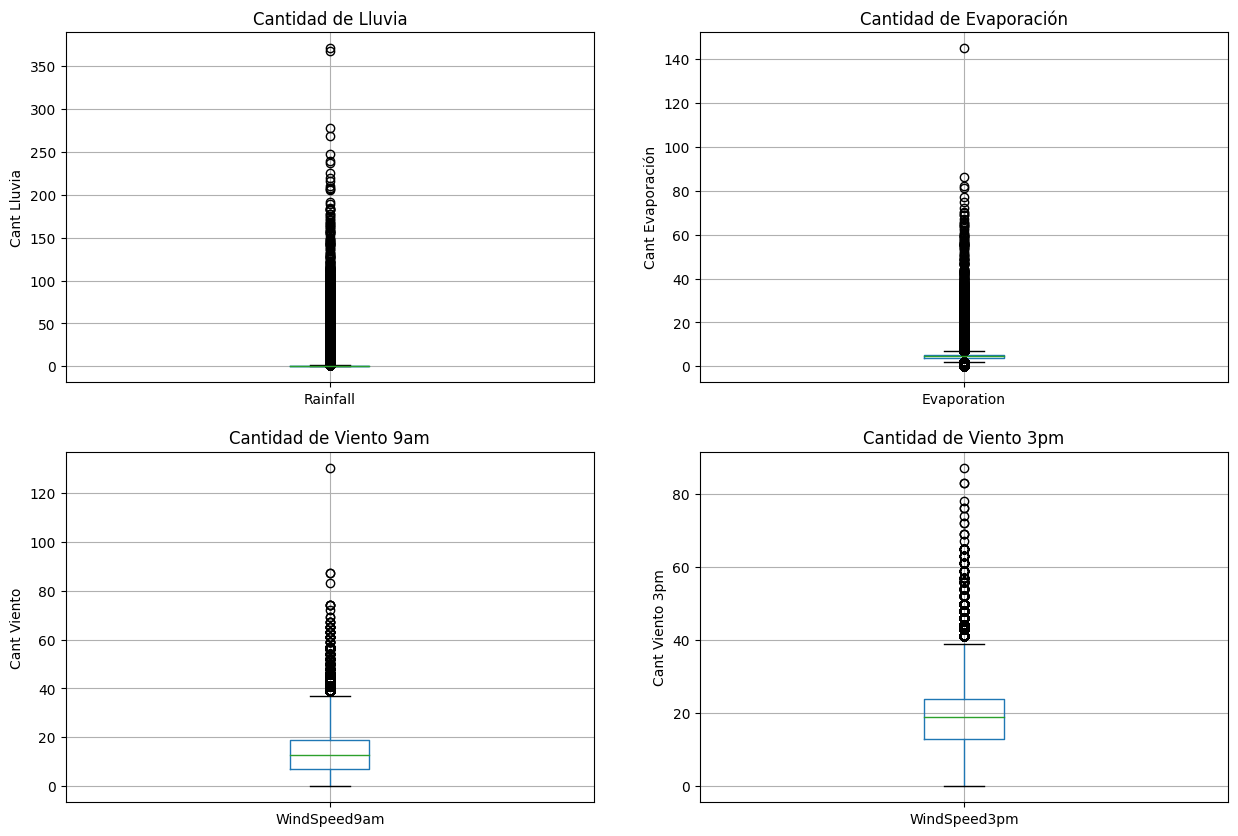

In [19]:
##Grafica para ver el ruido en los datos
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
fig = dataN.boxplot(column='Rainfall')
fig.set_title('Cantidad de Lluvia')
fig.set_ylabel('Cant Lluvia')

plt.subplot(2,2,2)
fig = dataN.boxplot(column='Evaporation')
fig.set_title('Cantidad de Evaporación')
fig.set_ylabel('Cant Evaporación')

plt.subplot(2,2,3)
fig = dataN.boxplot(column='WindSpeed9am')
fig.set_title('Cantidad de Viento 9am')
fig.set_ylabel('Cant Viento')

plt.subplot(2,2,4)
fig = dataN.boxplot(column='WindSpeed3pm')
fig.set_title('Cantidad de Viento 3pm')
fig.set_ylabel('Cant Viento 3pm')

Text(0, 0.5, 'Llover Mañana')

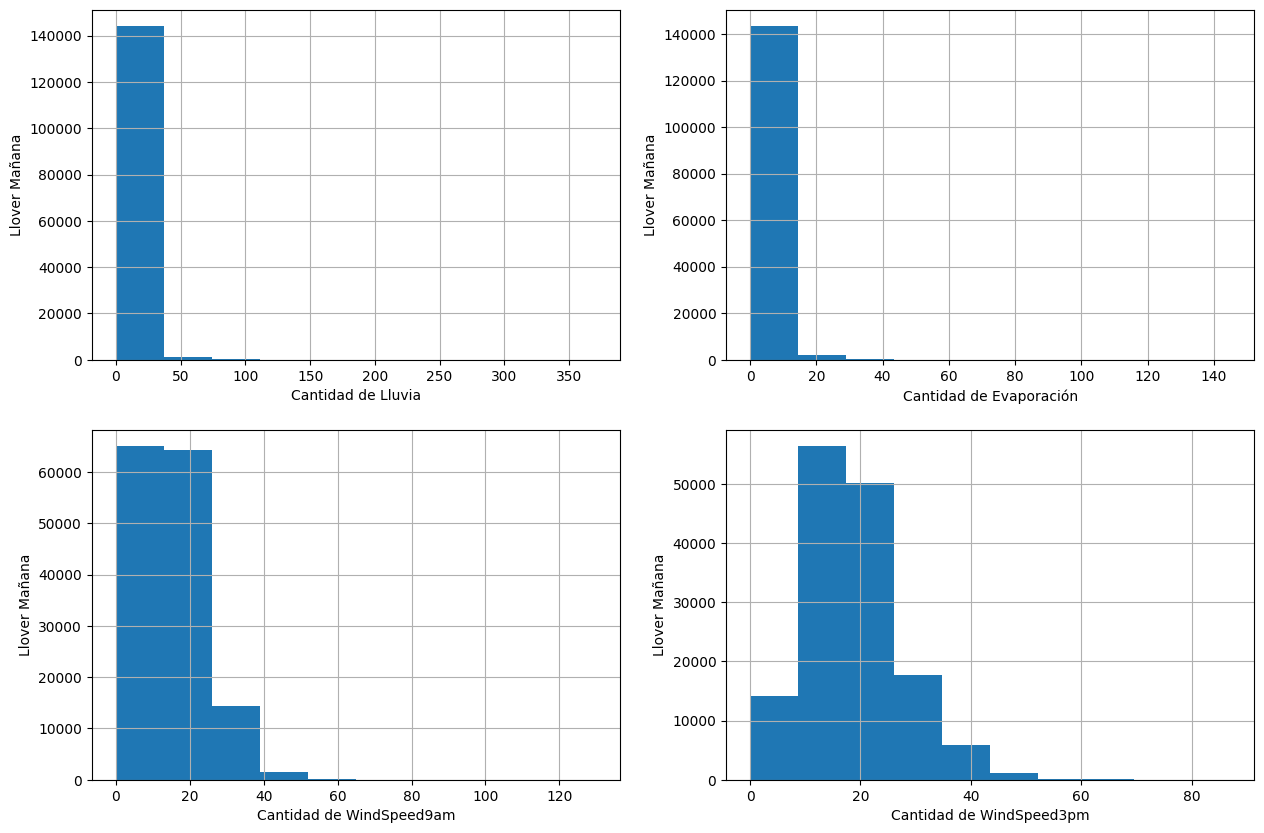

In [20]:
##Ver distribución de variables
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
fig = dataN.Rainfall.hist(bins=10)
fig.set_xlabel('Cantidad de Lluvia')
fig.set_ylabel('Llover Mañana')

plt.subplot(2,2,2)
fig = dataN.Evaporation.hist(bins=10)
fig.set_xlabel('Cantidad de Evaporación')
fig.set_ylabel('Llover Mañana')

plt.subplot(2,2,3)
fig = dataN.WindSpeed9am.hist(bins=10)
fig.set_xlabel('Cantidad de WindSpeed9am')
fig.set_ylabel('Llover Mañana')


plt.subplot(2,2,4)
fig = dataN.WindSpeed3pm.hist(bins=10)
fig.set_xlabel('Cantidad de WindSpeed3pm')
fig.set_ylabel('Llover Mañana')

In [21]:
##Rango del ruido de esas variable numéricas - rango intercuantilico
IQR1 = dataN.Rainfall.quantile(0.75)- dataN.Rainfall.quantile(0.25)
puntomin = dataN.Rainfall.quantile(0.25) - (IQR1*3)
puntomax = dataN.Rainfall.quantile(0.75) + (IQR1*3)

print('Rainfall el ruido esta entre los valores {} y {}'.format(puntomin, puntomax))
print('El rango IQR es:', IQR1)
##El ruido arranca desde >2.4

Rainfall el ruido esta entre los valores -1.7999999999999998 y 2.4
El rango IQR es: 0.6


In [22]:
IQR2 = dataN.Evaporation.quantile(0.75)- dataN.Evaporation.quantile(0.25)
puntomin = dataN.Evaporation.quantile(0.25) - (IQR2*3)
puntomax = dataN.Evaporation.quantile(0.75) + (IQR2*3)

print('Evaporation el ruido esta entre los valores {} y {}'.format(puntomin, puntomax))
print('El rango IQR es:', IQR2)

Evaporation el ruido esta entre los valores 0.39999999999999947 y 8.8
El rango IQR es: 1.2000000000000002


In [23]:
IQR3 = dataN.WindSpeed9am.quantile(0.75)- dataN.WindSpeed9am.quantile(0.25)
puntomin = dataN.WindSpeed9am.quantile(0.25) - (IQR3*3)
puntomax = dataN.WindSpeed9am.quantile(0.75) + (IQR3*3)

print('WindSpeed9am el ruido esta entre los valores {} y {}'.format(puntomin, puntomax))
print('El rango IQR es:', IQR3)


WindSpeed9am el ruido esta entre los valores -29.0 y 55.0
El rango IQR es: 12.0


In [24]:
IQR4 = dataN.WindSpeed3pm.quantile(0.75)- dataN.WindSpeed3pm.quantile(0.25)
puntomin = dataN.WindSpeed3pm.quantile(0.25) - (IQR4*3)
puntomax = dataN.WindSpeed3pm.quantile(0.75) + (IQR4*3)

##df['Age'] = np.where(df['Age']>57.0,IQR,df['Age'] )

print('WindSpeed3pm el ruido esta entre los valores {} y {}'.format(puntomin, puntomax))
print('El rango IQR es:', IQR4)

WindSpeed3pm el ruido esta entre los valores -20.0 y 57.0
El rango IQR es: 11.0


### Eliminación del Ruido

In [25]:
##Particiones X y
X= dataN.drop(['RainTomorrow'], axis=1)
y= dataN['RainTomorrow']

In [26]:
y.describe()

count    145460.000000
mean          0.219146
std           0.413669
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: RainTomorrow, dtype: float64

In [27]:
##Particiones X_train, X_test, y_train, y_test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [28]:
###Filtros
categoricos = [i for i in X_train.columns if X_train[i].dtype=='O']

categoricos

[]

In [29]:
numericos = [i for i in X_train.columns if X_train[i].dtype!='O']

numericos

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'Adelaide',
 'Albany',
 'Albury',
 'AliceSprings',
 'BadgerysCreek',
 'Ballarat',
 'Bendigo',
 'Brisbane',
 'Cairns',
 'Canberra',
 'Cobar',
 'CoffsHarbour',
 'Dartmoor',
 'Darwin',
 'GoldCoast',
 'Hobart',
 'Katherine',
 'Launceston',
 'Melbourne',
 'MelbourneAirport',
 'Mildura',
 'Moree',
 'MountGambier',
 'MountGinini',
 'Newcastle',
 'Nhil',
 'NorahHead',
 'NorfolkIsland',
 'Nuriootpa',
 'PearceRAAF',
 'Penrith',
 'Perth',
 'PerthAirport',
 'Portland',
 'Richmond',
 'Sale',
 'SalmonGums',
 'Sydney',
 'SydneyAirport',
 'Townsville',
 'Tuggeranong',
 'Uluru',
 'WaggaWagga',
 'Walpole',
 'Watsonia',
 'Williamtown',
 'Witchcliffe',
 'Wollongong',
 'Woomera']

In [30]:
### Rain today - Category encoders - pip install category_encoders
##pip install category_encoders
#import category_encoders as ce

#encoder = ce.BinaryEncoder(cols=['RainToday'])

#X_train = encoder.fit_transform(X_train)

#X_test = encoder.fit_transform(X_test)

#X_train.head()

In [31]:
###Normalizar
columnas = X_train.columns

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)

In [32]:
##Agregar nombres de columnas
X_train = pd.DataFrame(X_train, columns=[columnas])
X_test = pd.DataFrame(X_test, columns=[columnas])

In [33]:
##Agregar métricas
X_test.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
count,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000,...,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000,29092.000000
mean,0.481621,0.519747,0.006087,0.075419,0.558331,0.579762,0.257491,0.494078,0.557105,0.160874,...,0.021037,0.020384,0.011034,0.021174,0.021174,0.021415,0.021277,0.020384,0.020968,0.021243
std,0.151785,0.136934,0.022170,0.046267,0.193397,0.303148,0.101766,0.294031,0.281463,0.101699,...,0.143509,0.141311,0.104463,0.143967,0.143967,0.144765,0.144310,0.141311,0.143279,0.144196
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.372315,0.418919,0.000000,0.058140,0.573427,0.285714,0.187500,0.285714,0.285714,0.080460,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.477327,0.507722,0.000000,0.069767,0.587413,0.714286,0.250000,0.428571,0.571429,0.149425,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.591885,0.615830,0.001632,0.078488,0.608392,0.857143,0.304688,0.714286,0.857143,0.218391,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
###Revisión de Y - y_train, y_test
y_train.fillna(y_train.mode()[0], inplace=True)
y_test.fillna(y_test.mode()[0], inplace=True)


### Modelo Uno

In [35]:
from sklearn.linear_model import LogisticRegression

reglog1 = LogisticRegression(solver='liblinear', random_state=42)

reglog1.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [36]:
y_pred_test = reglog1.predict(X_test)

y_pred_test

array([1, 0, 0, ..., 0, 0, 0])

In [37]:
##Probabilidad de que no llueva mañana corresponde a cero 
reglog1.predict_proba(X_test)[:,0]

array([0.45482147, 0.98896772, 0.83523874, ..., 0.91068616, 0.76853167,
       0.89024887])

In [38]:
##Probabilidad de que llueva mañana corresponde a uno
reglog1.predict_proba(X_test)[:,1]

array([0.54517853, 0.01103228, 0.16476126, ..., 0.08931384, 0.23146833,
       0.10975113])

In [39]:
###Eficiencia del modelo con testeo
from sklearn.metrics import accuracy_score

print("La eficiencia del modelo de manera general es: {0:0.4f}".format(accuracy_score(y_test, y_pred_test)))

La eficiencia del modelo de manera general es: 0.8433


In [40]:
y_pred_train = reglog1.predict(X_train)

y_pred_train

array([0, 0, 0, ..., 0, 1, 0])

In [41]:
print("La eficiencia del modelo de manera general es: {0:0.4f}".format(accuracy_score(y_train, y_pred_train)))

La eficiencia del modelo de manera general es: 0.8484


In [42]:
reglog2 = LogisticRegression(C=100 ,solver='liblinear', random_state=42)

reglog2.fit(X_train, y_train)

LogisticRegression(C=100, random_state=42, solver='liblinear')

In [43]:
print("La eficiencia del modelo de manera general es C100: {:.4f}".format(reglog2.score(X_train, y_train)))
print("La eficiencia del modelo de manera general es C100: {:.4f}".format(reglog2.score(X_test, y_test)))

La eficiencia del modelo de manera general es C100: 0.8484
La eficiencia del modelo de manera general es C100: 0.8418


<Axes: >

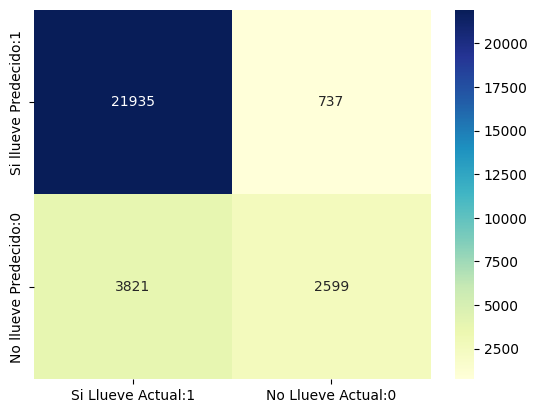

In [44]:
##Hacer la gráfica a petición de Sergio :D
##Métricas - Matriz de confusión
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Si Llueve Actual:1','No Llueve Actual:0'],
                         index=['Si llueve Predecido:1','No llueve Predecido:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91     22672
           1       0.78      0.40      0.53      6420

    accuracy                           0.84     29092
   macro avg       0.82      0.69      0.72     29092
weighted avg       0.84      0.84      0.82     29092



In [46]:
###Probabilidades de las primeras 10 filas de llueva mañana o no
y_pred_prob = reglog1.predict_proba(X_test)[0:10]

y_pred_prob

array([[0.45482147, 0.54517853],
       [0.98896772, 0.01103228],
       [0.83523874, 0.16476126],
       [0.89409566, 0.10590434],
       [0.62539263, 0.37460737],
       [0.96789963, 0.03210037],
       [0.98981536, 0.01018464],
       [0.76764751, 0.23235249],
       [0.80837108, 0.19162892],
       [0.56077016, 0.43922984]])

In [47]:
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Prob No Llueva (0)', 'Prob Llueva (1)'])

y_pred_prob_df

,Prob No Llueva (0),Prob Llueva (1)
0,0.454821,0.545179
1,0.988968,0.011032
2,0.835239,0.164761
3,0.894096,0.105904
4,0.625393,0.374607
5,0.967900,0.032100
6,0.989815,0.010185
7,0.767648,0.232352
8,0.808371,0.191629
9,0.560770,0.439230


In [48]:
###Grafica ROC - AUC

y_pred1 = reglog1.predict_proba(X_test)[:,1]

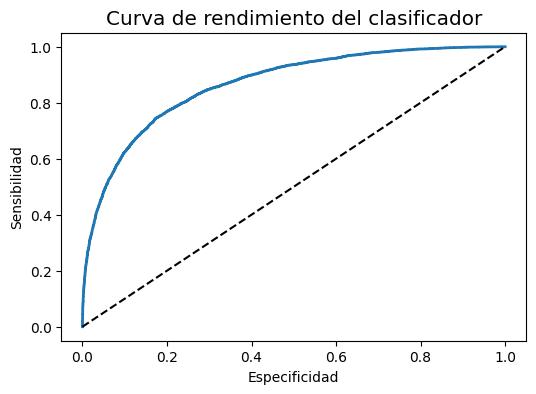

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred1, pos_label= 1) ## 'yes'

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1],[0,1], 'k--')

plt.rcParams['font.size']=12

plt.title('Curva de rendimiento del clasificador')

plt.xlabel('Especificidad')

plt.ylabel('Sensibilidad')

plt.show()

In [50]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred1)

roc_auc

0.8652885893258759

### Hiperparametrización GridSearchCV

In [51]:
from sklearn.model_selection import GridSearchCV

parametros = [{'penalty':['l1','l2']},
              {'C':[1, 10,100,1000]}]

gridsearch = GridSearchCV(estimator=reglog1,
                          param_grid=parametros,
                          scoring='accuracy',
                          cv=5,
                          verbose=0)

gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid=[{'penalty': ['l1', 'l2']}, {'C': [1, 10, 100, 1000]}],
             scoring='accuracy')

In [52]:
print('GridSearchCV Score: {:.4f}'.format(gridsearch.best_score_))

print('Parámetros:', gridsearch.best_params_)

print('Estimador:', gridsearch.best_estimator_)

LogisticRegression(penalty='l2', random_state=42, solver='liblinear')

GridSearchCV Score: 0.8483
Parámetros: {'penalty': 'l1'}
Estimador: LogisticRegression(penalty='l1', random_state=42, solver='liblinear')


LogisticRegression(random_state=42, solver='liblinear')

In [53]:
dataN.to_csv('clima.csv', index=False)

In [54]:
dataN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 70 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MinTemp           145460 non-null  float64
 1   MaxTemp           145460 non-null  float64
 2   Rainfall          145460 non-null  float64
 3   Evaporation       145460 non-null  float64
 4   Sunshine          145460 non-null  float64
 5   WindGustDir       145460 non-null  int32  
 6   WindGustSpeed     145460 non-null  float64
 7   WindDir9am        145460 non-null  int32  
 8   WindDir3pm        145460 non-null  int32  
 9   WindSpeed9am      145460 non-null  float64
 10  WindSpeed3pm      145460 non-null  float64
 11  Humidity9am       145460 non-null  float64
 12  Humidity3pm       145460 non-null  float64
 13  Pressure9am       145460 non-null  float64
 14  Pressure3pm       145460 non-null  float64
 15  Cloud9am          145460 non-null  float64
 16  Cloud3pm          14